# Mixture Models in Python

Based on Chapter 4 of http://web.stanford.edu/class/bios221/book/Chap-Mixtures.html

In [176]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotnine as gg

## Random numbers in Python

Numpy has a new random number generating facility (from 1.17 forward)

Older users might be familiar with `RandomState` or with just calling `np.random` directly, but this is supposed to be the new way to use the system

In [177]:
# Seed the generator for reproducibility
rg = np.random.default_rng(12345)

In [178]:
# Draw some random floats between [0, 1)
# This used to be called `rand` or `ranf`
five_floats = rg.random(5)
print(f'0.0 to 1.0: {five_floats}')

0.0 to 1.0: [0.22733602 0.31675834 0.79736546 0.67625467 0.39110955]


In [179]:
# Draw random ints from 1 to 10
# This used to be called `randint`
five_ints = rg.integers(1, 10, size=(5, ))
print(f'1 to 10: {five_ints}')

1 to 10: [8 3 6 6 2]


In [180]:
# Draw 5 samples from a 2 degree of freedom Chi Squared distribution
five_chisq = rg.chisquare(2, (5, ))
print(f'ChiSq 2-DOF: {five_chisq}')

ChiSq 2-DOF: [3.76803175 3.12275997 0.2653339  5.89518806 2.13025838]


The generator class has a ton of other methods that implement most of the standard univariate and multivariate distributions.

In [181]:
?np.random

## Data Generated by Interacting Processes

Often real data consists of a mixture of multiple data generating processes.

For instance, in RNA seq data:

* We sample transcripts from a perfectly reasonable positive skewed distribution **BUT**
* There's a sparse sampling process which randomly sprinkles zeros all over our data
* And there are some genes that have much higher counts than a simple model would predict

Here's an example:

In [182]:
# This is just some counts from an RNA seq experiment
# We're looking at how many times we detect a transcript, where each row is a gene
df = pd.read_csv('rna_counts.csv')
print(df.head())

print(f"Zero genes:    {np.sum(df['Counts'] == 0):,}")
print(f"One genes:     {np.sum(df['Counts'] == 1):,}")
print(f"Two genes:     {np.sum(df['Counts'] == 2):,}")

total_reads = np.sum(df['Counts'])
print(f"Total reads:   {total_reads:,}")
print(f"Max reads/gene: {np.max(df['Counts']):,}")

   Counts
0       0
1       0
2       0
3      83
4       3
Zero genes:    8,824
One genes:     1,802
Two genes:     1,024
Total reads:   168,210,459
Max reads/gene: 7,641,280


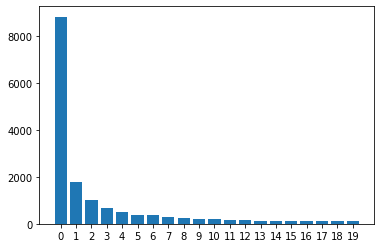

In [183]:
counts = np.arange(0, 20)
genes = [np.sum(df['Counts'] == c) for c in counts]

fig, ax = plt.subplots(1, 1)
ax.bar(counts, genes)
ax.set_xticks(counts);

We skipped Chapter 3 in the book (http://web.stanford.edu/class/bios221/book/Chap-Graphics.html), but it was all about how to get nice plots in R with `ggplot2`.

We can use the python package [seaborn](https://seaborn.pydata.org/index.html) to replace most of the basic ggplots, for instance, making distribution plots:

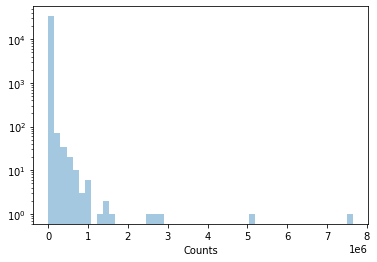

In [184]:
fig, ax = plt.subplots(1, 1)
sns.distplot(df['Counts'], ax=ax, kde=False)
ax.set_yscale('log')

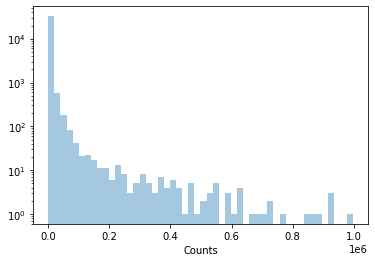

In [185]:
# Even if we toss the obvious outlier read counts, we still get a spike
sub_df = df[df['Counts'] < 1e6]

fig, ax = plt.subplots(1, 1)
sns.distplot(sub_df['Counts'], ax=ax, kde=False)
ax.set_yscale('log')

We can kind of fit this behavior with a power distribution, but it over-predicts reads towards the right

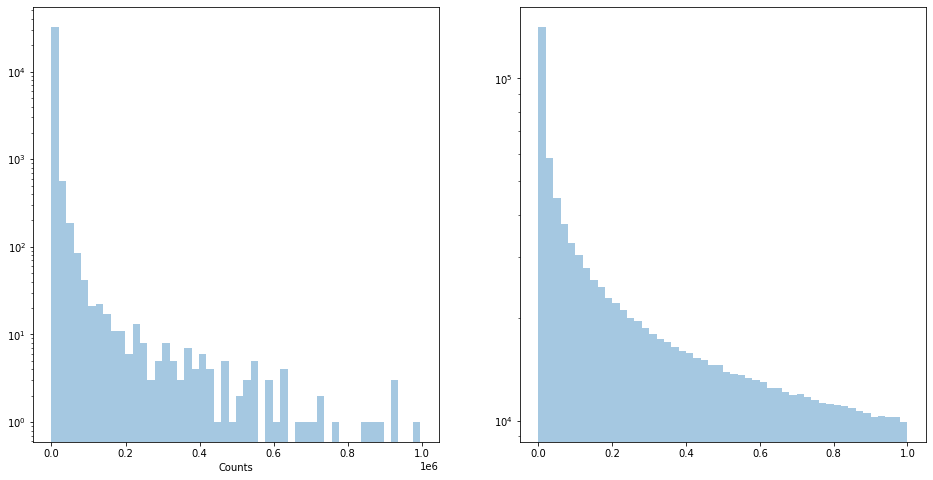

In [187]:
samples = rg.power(0.5, size=1000000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.distplot(sub_df['Counts'], ax=ax1, kde=False)
sns.distplot(samples, ax=ax2, kde=False)
ax1.set_yscale('log')
ax2.set_yscale('log')

And it under-predicts the counts to the left

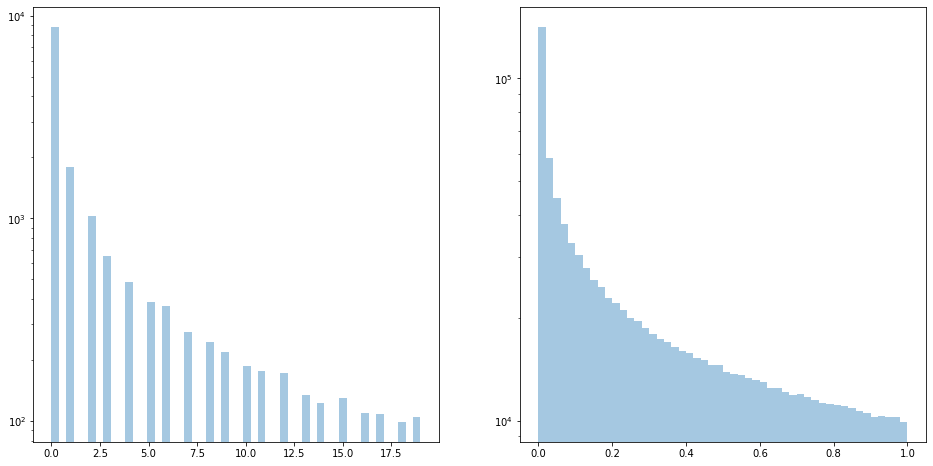

In [188]:
left_real = sub_df[sub_df['Counts'] < 20]
left_sim = samples[samples < 20]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.distplot(left_real, ax=ax1, kde=False)
sns.distplot(left_sim, ax=ax2, kde=False)
ax1.set_yscale('log')
ax2.set_yscale('log')

If we had a way to fit the parameters for a model that combined multiple processes we thought were important, we could start to build up large inference systems that reflect how our system works.

## Finite Mixtures

Let's create a simpler model. Two normal distributions with different means

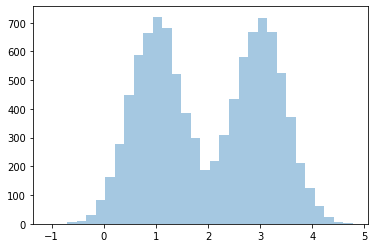

In [189]:
def double_normal_dist(flips: np.ndarray,
                       mean1: float = 1,
                       mean2: float = 3,
                       sd1: float = 0.5,
                       sd2: float = 0.5) -> np.ndarray:
    """ Simulate two normal distributions, selecting between them with a coin flip
    
    :param ndarray flips:
        The boolean array determining which distribution to sample from
    """
    num_ones = np.sum(flips)
    num_zeros = flips.shape[0] - num_ones
    
    # Pre-allocate the result array
    results = np.empty_like(flips, dtype=np.float)

    # If we got 0, sample the first distribution
    results[~flips] = rg.normal(mean1, sd1, num_zeros)
    
    # If we got 1, sample the second distribution
    results[flips] = rg.normal(mean2, sd2, num_ones)
    return results
    
# Flip 10,000 fair coins
flips = rg.random(10000) > 0.5

counts = double_normal_dist(flips)

sns.distplot(counts, kde=False);

### Sidebar: Seaborn is cool, but what if you like ggplot2?

There's a `ggplot2` clone in python called [plotnine](https://plotnine.readthedocs.io/en/stable/). It works pretty well:

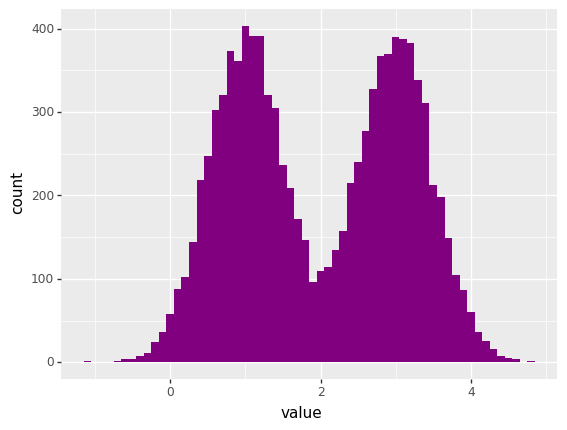

<ggplot: (321499069)>

In [190]:
# This might look crazy, but it's totally valid python syntax
(gg.ggplot(pd.DataFrame({'value': counts}), gg.aes(x='value'))
 + gg.geom_histogram(fill="purple", binwidth=0.1))

To convert a plot from `ggplot2` to `plotnine`:

1. Prefix all the `ggplot`, `aes` and `geom_*` calls with `gg.`
2. Replace all calls to `tibble` and `data.frame` with `pd.DataFrame`
3. Abuse how python parses expressions with way too many parenthesis (feels very LISPy)


If we up the number of samples and increase the number of bins, the curve gets smoother

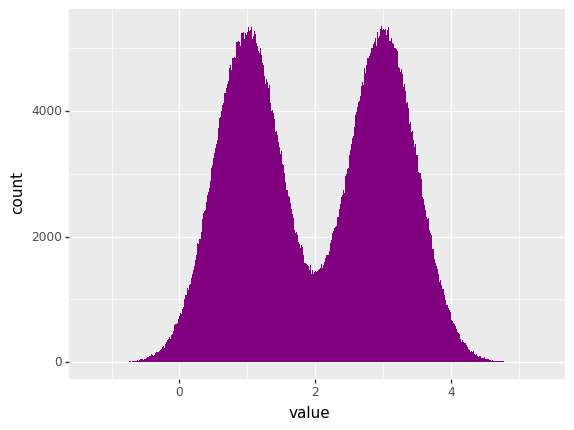

<ggplot: (326368413)>

In [191]:
flips = rg.random(1000000) > 0.5
counts = double_normal_dist(flips)

(gg.ggplot(pd.DataFrame({'value': counts}), gg.aes(x = 'value'))
 + gg.geom_histogram(fill="purple", bins=500))

A balanced mixture of two normals is a pretty cheesy distribution that doesn't need all the complex sampling machinery above. You can just write out the probability density function directly:

$f(x) = \frac{1}{2}\Phi_1(x) + \frac{1}{2}\Phi_2(x) $

And then directly evaluate it:

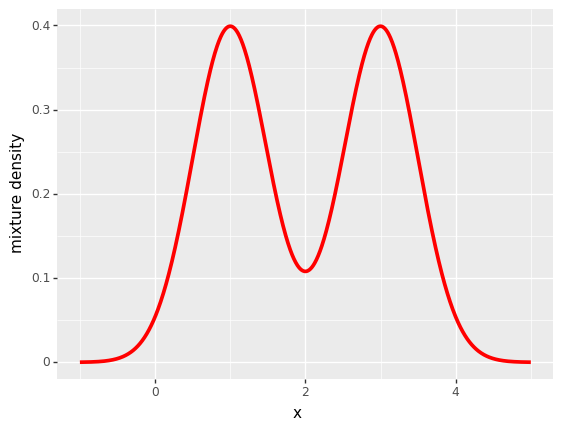

<ggplot: (326433417)>

In [192]:
# Sample the probability density function (pdf) between -1 and 5
x = np.linspace(-1, 5, 1000)
phi1 = stats.norm(loc=1, scale=0.5)
phi2 = stats.norm(loc=3, scale=0.5)
f = 0.5*phi1.pdf(x) + 0.5*phi2.pdf(x)

# Fancy ggplot again
(gg.ggplot(pd.DataFrame({'x': x, 'f': f}), gg.aes(x='x', y='f'))
 + gg.geom_line(color="red", size=1.5) + gg.ylab("mixture density"))

These kinds of models usually easy to fit when the peaks are well separated, but what if the peaks are closer?

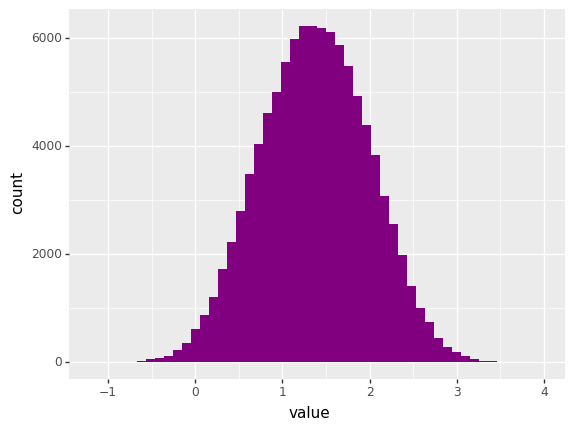

<ggplot: (329682337)>

In [193]:
flips = rg.random(100000) > 0.5
counts = double_normal_dist(flips, mean1=1.0, mean2=1.75)

(gg.ggplot(pd.DataFrame({'value': counts}), gg.aes(x = 'value'))
 + gg.geom_histogram(fill="purple", bins=50))

Since we have the `flips` matrix, we know which samples correspond to which distribution. This means we can back out the underlaying normals

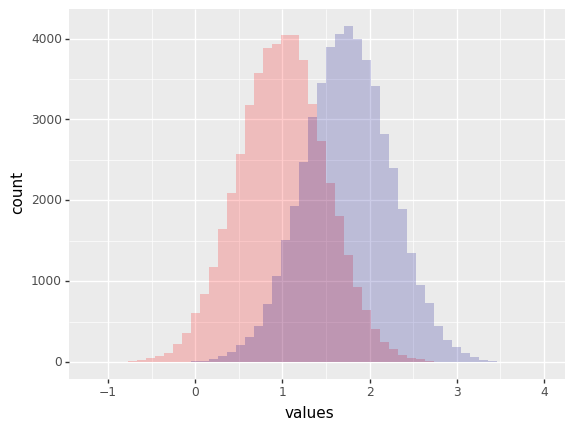

<ggplot: (330013297)>

In [194]:
flip_counts = pd.DataFrame({'values': counts, 'flips': flips})

(gg.ggplot(flip_counts, gg.aes(x='values'))
  + gg.geom_histogram(data=flip_counts[~flip_counts['flips']],
                      fill="red", alpha=0.2, bins=50)
  + gg.geom_histogram(data=flip_counts[flip_counts['flips']],
                      fill="darkblue", alpha=0.2, bins=50)) 

Despite the fact that the peaks of each distribution are clearly distinct, it's really hard to tell them apart when they're mixed together...

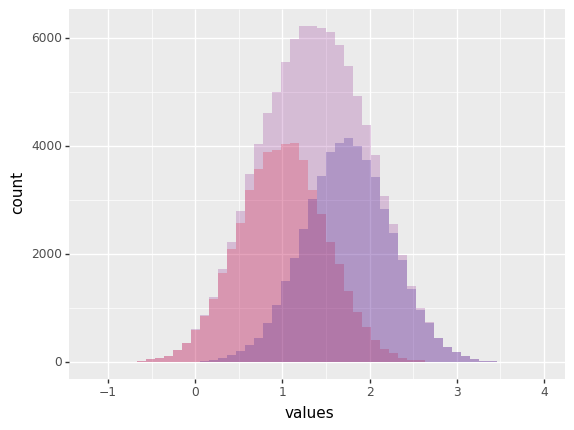

<ggplot: (327431325)>

In [195]:
(gg.ggplot(flip_counts, gg.aes(x='values'))
  + gg.geom_histogram(data=flip_counts[~flip_counts['flips']],
                      fill="red", alpha=0.2, bins=50)
  + gg.geom_histogram(data=flip_counts[flip_counts['flips']],
                      fill="darkblue", alpha=0.2, bins=50)
  + gg.geom_histogram(fill="purple", alpha=0.2, bins=50))

## Inferring the Flips - Expectation Maximization

If we didn't have the flips matrix, could we learn it?

We need to estimate two things:

1. Given an observation, did it come from from the left distribution, or the right?
2. Given our assignments for each observation, what are the most likely parameters for each distribution?

This sounds like an algorithm!

1. Hold the estimated distribution parameters constant. Estimate the most likely flips matrix.
2. Hold the flips matrix constant. Estimate the most likely distribution parameters.
3. Repeat until convergence (or it fails).

How well does this work?

Step 1: Try to assign flips:

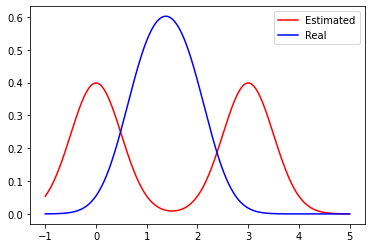

In [250]:
# Initial (bad) guesses
mean1 = 0.0
mean2 = 3.0

sig1 = 0.5
sig2 = 0.5

phi1 = stats.norm(loc=mean1, scale=sig1)
phi2 = stats.norm(loc=mean2, scale=sig2)

# See how bad our guess is
x = np.linspace(-1, 5, 1000)
est_dist = 0.5*phi1.pdf(x) + 0.5*phi2.pdf(x)

phi1 = stats.norm(loc=1.0, scale=sig1)
phi2 = stats.norm(loc=1.75, scale=sig2)
true_dist = 0.5*phi1.pdf(x) + 0.5*phi2.pdf(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x, est_dist, '-r', label='Estimated')
ax.plot(x, true_dist, '-b', label='Real')
ax.legend();

In [197]:
# Take the most probable assignment for each point
# A real implementation would use a soft weighting between the distributions
prob1 = phi1.pdf(counts)
prob2 = phi2.pdf(counts)

# How would this change with soft assignment?
# How about with multiple categories (more than 2 distributions)?
# How would you modify this to account for biased selection of one distribution?
est_flips = np.argmax(np.stack([prob1, prob2], axis=1), axis=1).astype(np.bool)

print(pd.DataFrame({
    'phi1': prob1,
    'phi2': prob2,
    'est_flips': est_flips,
    'true_flips': flips,
}).head(10))

       phi1      phi2  est_flips  true_flips
0  0.628336  0.575304      False       False
1  0.381867  0.020067      False       False
2  0.104678  0.698620       True        True
3  0.087181  0.664738       True        True
4  0.146009  0.752307       True        True
5  0.441048  0.733220       True       False
6  0.614243  0.067387      False       False
7  0.792509  0.306316      False        True
8  0.793869  0.299646      False       False
9  0.027109  0.435318       True        True


How well did our garbage estimator do?

In [198]:
# Correct answers
total = est_flips.shape[0]

true_positives = np.sum(np.logical_and(est_flips, flips))
true_negatives = np.sum(np.logical_and(~est_flips, ~flips))

# We predict True, the actual answer is False
false_positives = np.sum(np.logical_and(est_flips, ~flips))

# We predict False, the actual answer is True
false_negatives = np.sum(np.logical_and(~est_flips, flips))

print(f'TP Rate: {true_positives/total:0.1%}')
print(f'TN Rate: {true_negatives/total:0.1%}')
print(f'FP Rate: {false_positives/total:0.1%}')
print(f'FN Rate: {false_negatives/total:0.1%}')

# Correct vs incorrect assignment
print(f'Correct Rate:   {(true_positives+true_negatives)/total:0.1%}')
print(f'Incorrect Rate: {(false_positives+false_negatives)/total:0.1%}')


TP Rate: 38.7%
TN Rate: 38.7%
FP Rate: 11.3%
FN Rate: 11.3%
Correct Rate:   77.4%
Incorrect Rate: 22.6%


Where are the samples that we are making mistakes on?

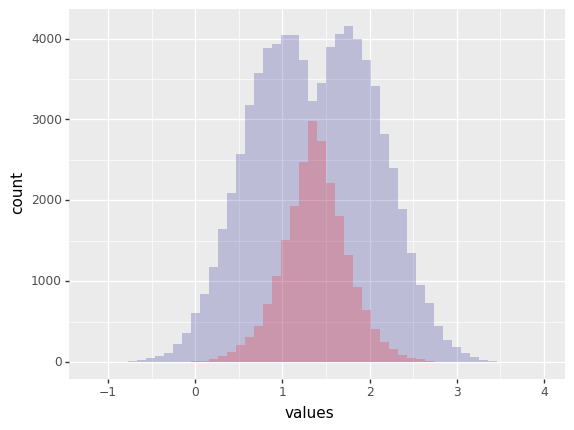

<ggplot: (329747773)>

In [201]:
correct_calls = est_flips == flips
incorrect_calls = ~correct_calls

(gg.ggplot(flip_counts, gg.aes(x='values'))
  + gg.geom_histogram(data=flip_counts[correct_calls],
                      fill="darkblue", alpha=0.2, bins=50)
  + gg.geom_histogram(data=flip_counts[incorrect_calls],
                      fill="red", alpha=0.2, bins=50))

So our guess with bad parameters is already >75% accurate at calling flips.

All the errors are in the region that overlaps between the two distributions. 

Step 2: Use our already surprisingly good guesses to estimate better distribution parameters...

In [202]:
# The maximum likelihood estimator of the mean of a normal distribution is just the sample mean
est_mean1 = np.mean(counts[~est_flips])
est_mean2 = np.mean(counts[est_flips])

print(f'New mean1: {est_mean1:0.2f}')
print(f'New mean2: {est_mean2:0.2f}')

New mean1: 0.87
New mean2: 1.88


Step 3: Lather, rinse, repeat...

In [203]:
for i in range(10):
    print(f'EM Step {i+1}')
    # Step 1:
    phi1 = stats.norm(loc=est_mean1, scale=sig1)
    phi2 = stats.norm(loc=est_mean2, scale=sig2)
    
    prob1 = phi1.pdf(counts)
    prob2 = phi2.pdf(counts)
    
    est_flips = np.argmax(np.stack([prob1, prob2], axis=1), axis=1).astype(np.bool)

    total = est_flips.shape[0]
    true_positives = np.sum(np.logical_and(est_flips, flips))
    true_negatives = np.sum(np.logical_and(~est_flips, ~flips))
    print(f'Correct Rate:   {(true_positives+true_negatives)/total:0.1%}')
    
    # Step 2:
    est_mean1 = np.mean(counts[~est_flips])
    est_mean2 = np.mean(counts[est_flips])
    
    print(f'New mean1: {est_mean1:0.2f}')
    print(f'New mean2: {est_mean2:0.2f}')

EM Step 1
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 2
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 3
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 4
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 5
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 6
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 7
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 8
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 9
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88
EM Step 10
Correct Rate:   77.4%
New mean1: 0.87
New mean2: 1.88


And we're stuck at around 77.5% correct assignment. This is obviously a terrible estimator that doesn't work right:

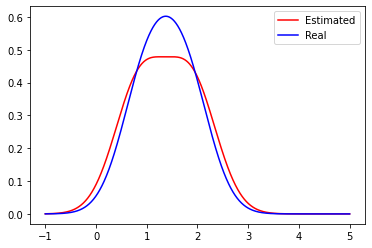

In [249]:
phi1 = stats.norm(loc=est_mean1, scale=sig1)
phi2 = stats.norm(loc=est_mean2, scale=sig2)

x = np.linspace(-1, 5, 1000)
est_dist = 0.5*phi1.pdf(x) + 0.5*phi2.pdf(x)

phi1 = stats.norm(loc=1.0, scale=sig1)
phi2 = stats.norm(loc=1.75, scale=sig2)
true_dist = 0.5*phi1.pdf(x) + 0.5*phi2.pdf(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x, est_dist, '-r', label='Estimated')
ax.plot(x, true_dist, '-b', label='Real')
ax.legend();


Where are the incorrectly assigned points?

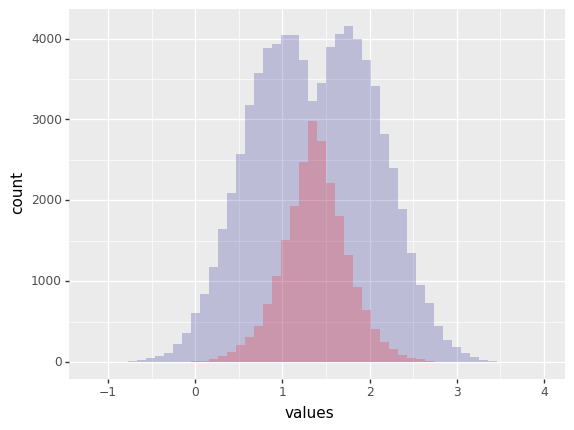

<ggplot: (332507653)>

In [204]:
correct_calls = est_flips == flips
incorrect_calls = ~correct_calls

(gg.ggplot(flip_counts, gg.aes(x='values'))
  + gg.geom_histogram(data=flip_counts[correct_calls],
                      fill="darkblue", alpha=0.2, bins=50)
  + gg.geom_histogram(data=flip_counts[incorrect_calls],
                      fill="red", alpha=0.2, bins=50))

So considering this is the greediest version of this algorithm, and most of the calls are ambiguous, we ended up with pretty good estimates.

## Multiple Components

Instead of just two components, we can have a mixture of several

Here's a mixture of 4 different nucleotides with their expected masses and frequencies:

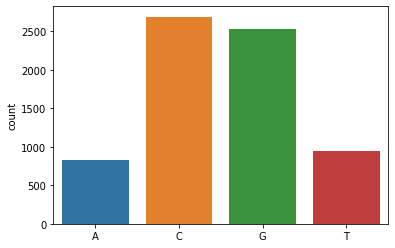

In [166]:
masses = {'A': 331, 'C': 307, 'G': 347, 'T': 322}
probs  = {'A': 0.12, 'C': 0.38, 'G': 0.36, 'T': 0.14}
N  = 7000
sd = 3

# Sample bases, in proportion to the probabilities given
choices, weights = zip(*probs.items())
sample = rg.choice(list(choices), size=(N, ), p=list(weights), replace=True)

# Make sure our sample has the expected proportions
sns.countplot(sample, order=['A', 'C', 'G', 'T']);

In [169]:
# Draw according to the multiple distributions
quadwts = np.empty_like(sample, dtype=np.float)
for key, mean in masses.items():
    mask = sample == key
    quadwts[mask] = rg.normal(mean, sd, np.sum(mask))


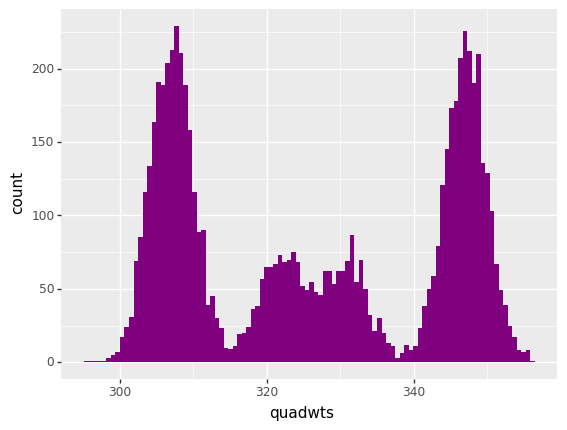

<ggplot: (333172497)>

In [231]:
# Store as a dataframe for easier plotting
quadwts_calls = pd.DataFrame({'quadwts': quadwts, 'truth': sample})

(gg.ggplot(quadwts_calls, gg.aes(x='quadwts'))
 + gg.geom_histogram(bins=100, fill="purple"))

Assume this time that we want to know the proportions instead of the means

In [214]:
# Initial guess - uniform proportions
proportions = [0.25, 0.25, 0.25, 0.25]

# We could also simultaneously try to estimate the means or the deviations.
# With too many free parameters, the model can quickly become impossible to fit...
means = [331, 307, 347, 322]
sd = 3

# Step 1 - Assign based on most likely call
phis = [stats.norm(loc=m, scale=sd) for m in means]

# Put each point into a bucket based on how likely it is to belong to one base
probs = np.array([p*phi.pdf(quadwts) for p, phi in zip(proportions, phis)])
probs = probs/np.sum(probs, axis=0)


[[4.32342059e-19 2.69301782e-20 1.62933903e-18 9.06242049e-01
  1.97394041e-07 6.10332143e-01]
 [9.99999994e-01 9.99999999e-01 9.99999986e-01 1.87417470e-22
  1.19114012e-40 3.80205894e-10]
 [8.94260883e-47 8.75286977e-49 8.16151646e-46 9.37458511e-02
  9.99999803e-01 3.02702677e-10]
 [6.02005962e-09 1.06195993e-09 1.37948117e-08 1.21001296e-05
  1.24531281e-16 3.89667857e-01]]


In [216]:
print(pd.DataFrame({'truth': sample,
                    'P(A)': probs[0, :],
                    'P(C)': probs[1, :],
                    'P(G)': probs[2, :],
                    'P(T)': probs[3, :]}).head())

  truth          P(A)          P(C)          P(G)          P(T)
0     C  4.323421e-19  1.000000e+00  8.942609e-47  6.020060e-09
1     C  2.693018e-20  1.000000e+00  8.752870e-49  1.061960e-09
2     C  1.629339e-18  1.000000e+00  8.161516e-46  1.379481e-08
3     A  9.062420e-01  1.874175e-22  9.374585e-02  1.210013e-05
4     G  1.973940e-07  1.191140e-40  9.999998e-01  1.245313e-16


In [217]:
# Convert the soft probabilities to calls
est_index = np.argmax(probs, axis=0)

est_sample = np.array(['A', 'C', 'G', 'T'])[est_index]

print(est_sample[:10])
print(sample[:10])

['C' 'C' 'C' 'A' 'G' 'A' 'A' 'T' 'A' 'A']
['C' 'C' 'C' 'A' 'G' 'T' 'A' 'T' 'A' 'A']


So already, we appear to be more or less calling things correctly

In [229]:
# How well are we doing overall?
total = est_sample.shape[0]
correct_calls = est_sample == sample
incorrect_calls = est_sample != sample

print(f'Correct Calls:   {np.sum(correct_calls)/total:0.2%}')
print(f'Incorrect Calls: {np.sum(incorrect_calls)/total:0.2%}')


Correct Calls:   97.51%
Incorrect Calls: 2.49%


Where are the problem children located?

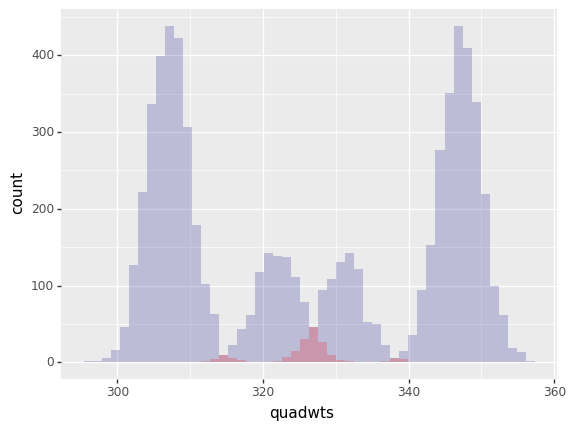

<ggplot: (329758889)>

In [233]:
(gg.ggplot(quadwts_calls, gg.aes(x='quadwts'))
 + gg.geom_histogram(data=quadwts_calls[correct_calls],
                      fill="darkblue", alpha=0.2, bins=50)
 + gg.geom_histogram(data=quadwts_calls[incorrect_calls],
                      fill="red", alpha=0.2, bins=50))

So already, the only real problems we're having are again at the overlaps.

Cool, so lets try and learn some parameter values

In [236]:
# Step 2 - Update parameters based on the calls

# MLE of the mixing parameter is just the proportions
# (For real implementations, this needs to be done with logs or you will have numerical issues)
est_proportions = np.sum(probs, axis=1)/probs.shape[1]
print(est_proportions)


[0.12396603 0.38204214 0.36036839 0.13362343]


In [240]:
# Step 3 - Repeat until convergence

# Assign based on most likely call
phis = [stats.norm(loc=m, scale=sd) for m in means]

# Put each point into a bucket based on how likely it is to belong to one base
probs = np.array([p*phi.pdf(quadwts) for p, phi in zip(est_proportions, phis)])
probs = probs/np.sum(probs, axis=0)

# Estimate the new proportions
est_proportions = np.sum(probs, axis=1)/probs.shape[1]
print(est_proportions)

[0.12156555 0.38448392 0.36169365 0.13225688]


How did we do?

In [241]:
# Convert the soft probabilities to calls
est_index = np.argmax(probs, axis=0)
est_sample = np.array(['A', 'C', 'G', 'T'])[est_index]

print(est_sample[:10])
print(sample[:10])

['C' 'C' 'C' 'A' 'G' 'A' 'A' 'T' 'A' 'A']
['C' 'C' 'C' 'A' 'G' 'T' 'A' 'T' 'A' 'A']


Correct Calls:   97.63%
Incorrect Calls: 2.37%


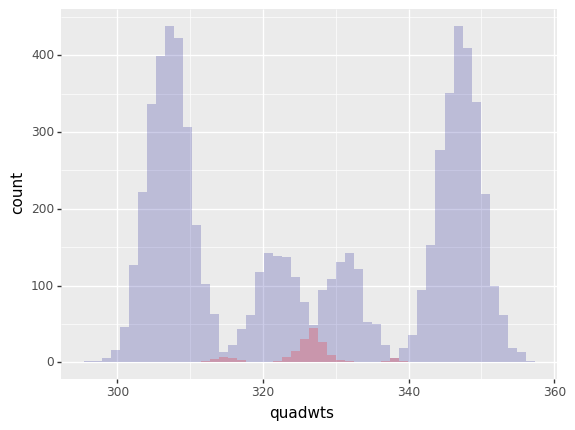

<ggplot: (332684621)>

In [243]:
# How well are we doing overall?
total = est_sample.shape[0]
correct_calls = est_sample == sample
incorrect_calls = est_sample != sample

print(f'Correct Calls:   {np.sum(correct_calls)/total:0.2%}')
print(f'Incorrect Calls: {np.sum(incorrect_calls)/total:0.2%}')

(gg.ggplot(quadwts_calls, gg.aes(x='quadwts'))
 + gg.geom_histogram(data=quadwts_calls[correct_calls],
                      fill="darkblue", alpha=0.2, bins=50)
 + gg.geom_histogram(data=quadwts_calls[incorrect_calls],
                      fill="red", alpha=0.2, bins=50))

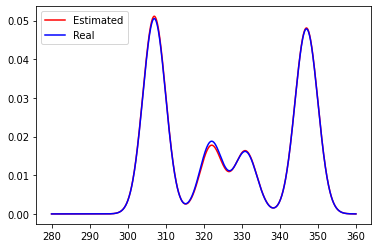

In [252]:
true_probs = [0.12, 0.38, 0.36, 0.14]

phis = [stats.norm(loc=m, scale=sd) for m in means]

x = np.linspace(280, 360, 1000)
est_dist = np.sum([p*phi.pdf(x) for p, phi in zip(est_proportions, phis)], axis=0)
true_dist = np.sum([p*phi.pdf(x) for p, phi in zip(true_probs, phis)], axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(x, est_dist, '-r', label='Estimated')
ax.plot(x, true_dist, '-b', label='Real')
ax.legend();

Not bad...

## Conclusions

Mixture models are cool.

EM seems like a super naive algorithm, but it works pretty well in a lot of cases.

If you like this, lots more stuff in http://web.stanford.edu/class/bios221/book/Chap-Mixtures.html